In [15]:
%reload_ext autoreload
%autoreload 2

from NSGPy.torch.model import NSGPRegression
import torch
import numpy as np
from pyDOE2.doe_lhs import lhs
import matplotlib.pyplot as plt

### Generate train data

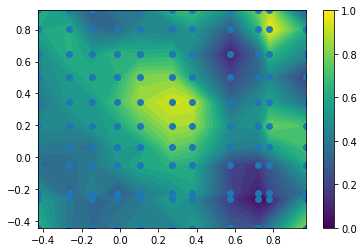

In [16]:
n = 11
np.random.seed(0)

def simulate(a, b):
    bi = np.pi * (2*a + 0.5*b + 1)
    return 0.1 * (np.sin(a*bi) + np.sin(b.T*bi))

x1 = np.sort(lhs(1, 11, random_state=0)*1.5 - 0.5, axis=0)
x2 = np.sort(lhs(1, 11, random_state=1)*1.5 - 0.5, axis=0)
X1, X2 = np.meshgrid(x1, x2)
X = np.array([(a,b) for a,b in zip(X1.ravel(), X2.ravel())])
y = simulate(X[:,0], X[:,1]).reshape(-1,1) + np.random.normal(0, 0.025, (121,1))

plt.contourf(X1, X2, y.reshape(n,n), levels=30);
plt.scatter(X[:,0], X[:,1]);
plt.colorbar();

X = torch.tensor(X)
y = torch.tensor(y)

### Scaling

In [17]:
X = (X - X.mean(dim=0))/X.std(dim=0)
y = (y - y.mean())/y.std()

### Training

In [18]:
torch.manual_seed(0)
model = NSGPRegression(X, y, 5, 0)
print(model.params)
# %debug
model.optimize_auto(1000, lr=0.001, gran=100, m=0, optim='adam')
with torch.no_grad():
    mean, var = model.predict(X)
    mean = mean.view(-1)
    std2 = torch.sqrt(var.diag())*2
    ls = model.get_LS(X)

{'local_gp_std': tensor([1.9701, 1.7078], requires_grad=True), 'local_gp_ls': tensor([1.4594, 1.9207], requires_grad=True), 'local_gp_noise': tensor([1.6450, 1.7911], requires_grad=True), 'latent_ls': tensor([[1.1786, 1.3511],
        [1.5813, 1.2882],
        [1.4529, 1.1768],
        [1.3553, 1.6219],
        [1.4818, 1.4408]], requires_grad=True), 'global_gp_std': tensor([1.4073], requires_grad=True), 'global_gp_noise': tensor([1.2054], requires_grad=True)}
49.32104682184301
46.19933987899682
42.66318861705746
37.22050210627301
29.334489905453665
23.581386080677973
19.7543084361459
17.89229220572509
16.59163119201492
15.212031957784774


### Testing

In [24]:
np.random.seed(0)
n = 31
x1_test = np.sort(lhs(1, n, random_state=3)*1.5 - 0.5, axis=0)
x2_test = np.sort(lhs(1, n, random_state=4)*1.5 - 0.5, axis=0)
X1_test, X2_test = np.meshgrid(x1_test, x2_test)

X_test = torch.tensor(np.array([(a,b) for a,b in zip(X1_test.ravel(), X2_test.ravel())]))
y_test = torch.tensor(np.array([simulate(a,b) for a,b in zip(X1_test.ravel(), X2_test.ravel())]).reshape(-1,1))
# print(X_test.shape, y_test.shape)

X_test = (X_test - X_test.mean(dim=0))/X_test.std(dim=0)
y_test = (y_test - y_test.mean())/y_test.std()

with torch.no_grad():
    mean, var = model.predict(X_test)
    ls = model.get_LS(X_test)
    print(torch.mean(torch.square(y_test-mean))/torch.var(y_test))

tensor(0.0782)


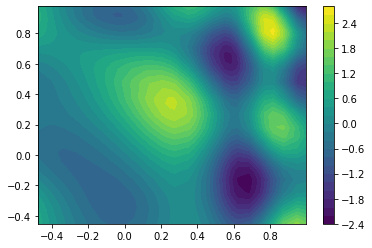

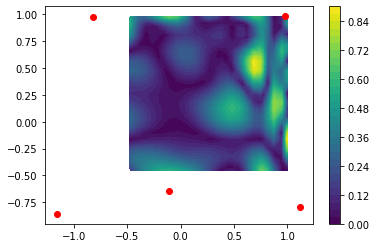

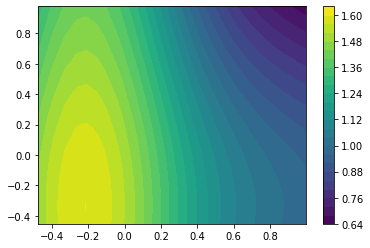

In [25]:
plt.contourf(X1_test, X2_test, mean.reshape(n,n), levels=30);
plt.colorbar();

plt.figure()
plt.scatter(model.X_bar[:,0], model.X_bar[:,1], c='r',zorder=10)
plt.contourf(X1_test, X2_test, torch.abs(mean.reshape(n,n)-y_test.reshape(n,n)), levels=30);
plt.colorbar();

plt.figure()
plt.contourf(X1_test, X2_test, torch.norm(torch.cat(ls, dim=1), dim=1).reshape(n,n), levels=30);
plt.colorbar();

In [26]:
model.params

{'local_gp_std': tensor([1.1860, 1.2695], requires_grad=True),
 'local_gp_ls': tensor([0.8527, 2.3271], requires_grad=True),
 'local_gp_noise': tensor([0.8648, 0.4573], requires_grad=True),
 'latent_ls': tensor([[0.7575, 0.8378],
         [1.7055, 0.7287],
         [0.6076, 0.6168],
         [1.7261, 1.0912],
         [0.6137, 0.9162]], requires_grad=True),
 'global_gp_std': tensor([2.0262], requires_grad=True),
 'global_gp_noise': tensor([0.4289], requires_grad=True)}

### Comparing with Stationary GP

 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add



Name : GP regression
Objective : 109.79749088631971
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   2.2597195490473054  |      +ve      |        
  rbf.lengthscale          |                 (2,)  |      +ve      |        
  Gaussian_noise.variance  |  0.08625341863329403  |      +ve      |        


(GP_regression.rbf.lengthscale:
 Param([0.40229334, 0.58871441]),
 array([0.29368932]))

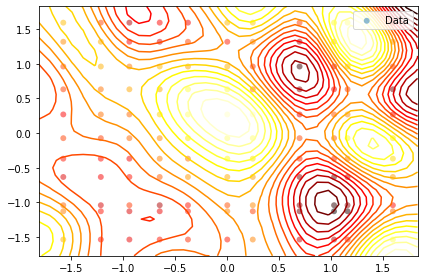

In [28]:
np.random.seed(0)
import GPy
m = GPy.models.GPRegression(X.numpy(), y.numpy(), GPy.kern.RBF(2, ARD=True))
m.optimize_restarts(20, verbose=False);
m.plot()
print(m)
m.kern.lengthscale, m['Gaussian_noise.variance']**.5

0.09252618332503465

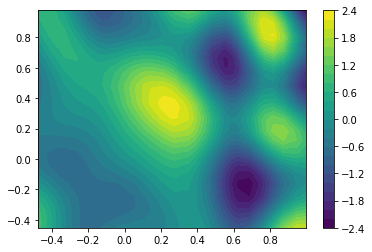

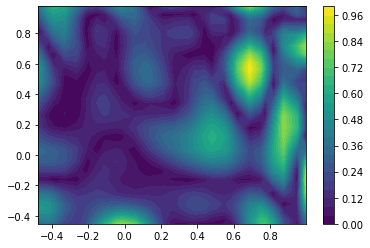

In [29]:
pred_y = m.predict(X_test.numpy())[0]

plt.contourf(X1_test, X2_test, pred_y.reshape(n,n), levels=30)
plt.colorbar()

plt.figure()
plt.contourf(X1_test, X2_test, np.abs(pred_y.reshape(n,n)-y_test.numpy().reshape(n,n)), levels=30)
plt.colorbar();
np.mean(np.square(y_test.numpy().ravel()-pred_y.ravel()))/np.var(y_test.numpy())